# Challenge: Loan Data 📈

### **Developing a Machine Learning Model for Credit Risk Prediction**

The primary goal of this project is to build a machine learning model that can predict the **likelihood of default** for loan applicants. By analyzing historical loan data, we will identify key factors that influence credit risk.

In [9]:
# Import Libraries
import os
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report,roc_auc_score,recall_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline,make_pipeline

## Import Data
This step is to **load the data** from the CSV file into a Pandas DataFrame. We will use `df.shape` and `df.info()` to see a brief summary of the data. Next, we will create a distribution graph to **find *outliers*** and gain an initial understanding of the data.

In [82]:
# Get Data
filepath = "data/loan_data_2007_2014.csv"
data = pd.read_csv(filepath,low_memory=False)
# Check Data
print(data.shape)
data.head()

(466285, 75)


,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
data.describe()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
count,466285.000000,4.662850e+05,4.662850e+05,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,4.662810e+05,466285.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,3.960090e+05,0.0,0.0,0.0
mean,233142.000000,1.307973e+07,1.459766e+07,14317.277577,14291.801044,14222.329888,13.829236,432.061201,7.327738e+04,17.218758,...,NaN,NaN,NaN,NaN,NaN,NaN,3.037909e+04,NaN,NaN,NaN
std,134605.029472,1.089371e+07,1.168237e+07,8286.509164,8274.371300,8297.637788,4.357587,243.485550,5.496357e+04,7.851121,...,NaN,NaN,NaN,NaN,NaN,NaN,3.724713e+04,NaN,NaN,NaN
min,0.000000,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.420000,15.670000,1.896000e+03,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN
25%,116571.000000,3.639987e+06,4.379705e+06,8000.000000,8000.000000,8000.000000,10.990000,256.690000,4.500000e+04,11.360000,...,NaN,NaN,NaN,NaN,NaN,NaN,1.350000e+04,NaN,NaN,NaN
50%,233142.000000,1.010790e+07,1.194108e+07,12000.000000,12000.000000,12000.000000,13.660000,379.890000,6.300000e+04,16.870000,...,NaN,NaN,NaN,NaN,NaN,NaN,2.280000e+04,NaN,NaN,NaN
75%,349713.000000,2.073121e+07,2.300154e+07,20000.000000,20000.000000,19950.000000,16.490000,566.580000,8.896000e+04,22.780000,...,NaN,NaN,NaN,NaN,NaN,NaN,3.790000e+04,NaN,NaN,NaN
max,466284.000000,3.809811e+07,4.086083e+07,35000.000000,35000.000000,35000.000000,26.060000,1409.990000,7.500000e+06,39.990000,...,NaN,NaN,NaN,NaN,NaN,NaN,9.999999e+06,NaN,NaN,NaN


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

In [21]:
data["loan_status"].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

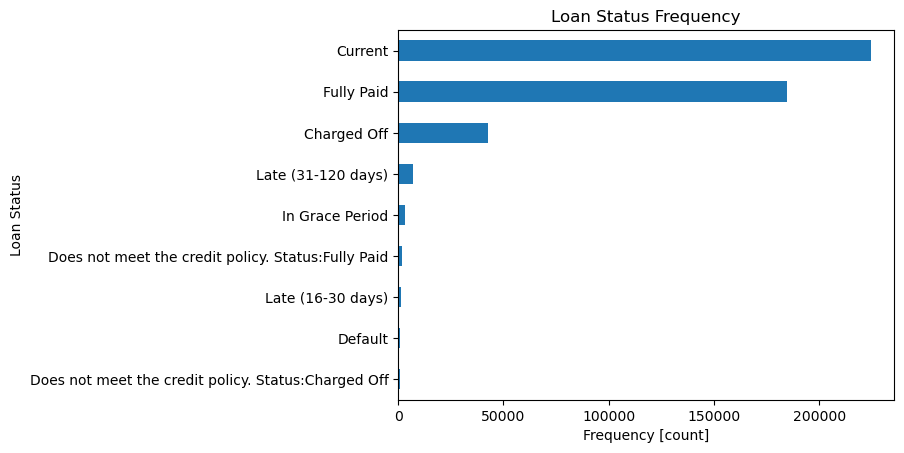

In [23]:
# Create Horizontal Bar Chart of 'loan_status'
data["loan_status"].value_counts().sort_values(ascending=True).plot(kind="barh")
# Label
plt.xlabel("Frequency [count]")
plt.ylabel("Loan Status")
plt.title("Loan Status Frequency")
plt.show()

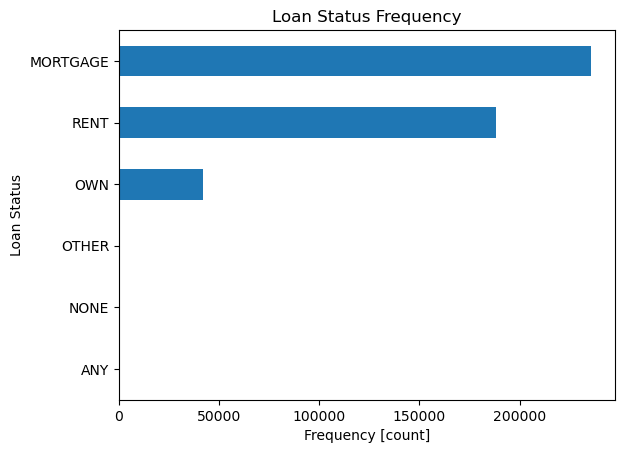

In [25]:
# Create Horizontal Bar Chart of 'loan_status'
data["home_ownership"].value_counts().sort_values(ascending=True).plot(kind="barh")
# Label
plt.xlabel("Frequency [count]")
plt.ylabel("Loan Status")
plt.title("Loan Status Frequency")
plt.show()

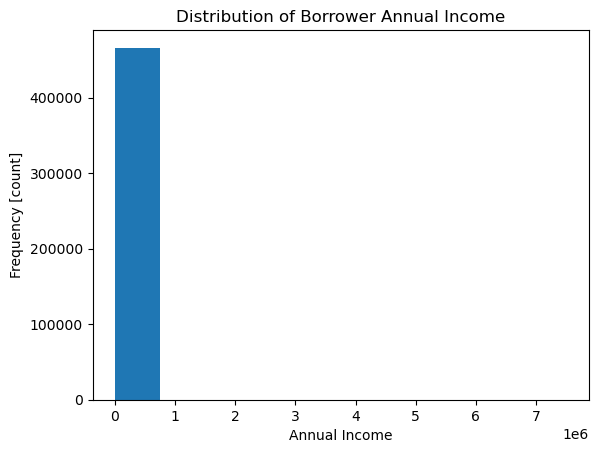

In [27]:
plt.hist(data["annual_inc"]);
plt.xlabel("Annual Income")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Borrower Annual Income")
plt.show()

The histogram shows that the distribution of borrower annual income is right-skewed, as the majority of borrowers have low incomes. A box plot will now be used to confirm the presence of outliers.

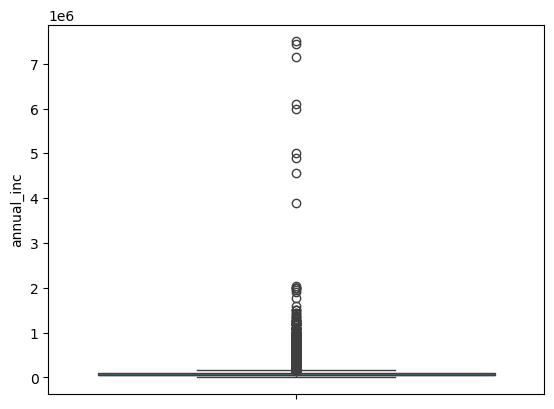

In [30]:
sns.boxplot(data["annual_inc"]);
plt.show()

The Boxplot confirm us that the "annual_inc" column has outliers

## Wrangle Data
In this step, we create a **`wrangle` function** to clean and prepare the lending data for modeling. The function performs a series of operations to ensure the dataset is ready for analysis.

In [96]:
# Create Wrangle Function
def wrangle(data):
    """Cleans and prepares the lending data for modeling."""
    try:
        # Create a DataFrame
        df = data
    
        # --- Feature Engineering ---
        # Create a new feature for the proportion of open accounts.
        df["prop_open_acc"] = df["open_acc"] / df["total_acc"].replace(0, 1)
    
        # Get the reference date (latest loan issue date)
        issue_d_datetime = pd.to_datetime(df['issue_d'], format='%b-%y')
        date_ref = issue_d_datetime.max()
        # Convert earliest_cr_line and correct the century error
        df["earliest_cr_line"] = pd.to_datetime(df["earliest_cr_line"], format="%b-%y")
        df["earliest_cr_line"] = df["earliest_cr_line"].apply(lambda x: x - pd.DateOffset(years=100) if x > date_ref else x)
        # Calculate credit history length in months
        df['credit_history_length_months'] = (
            (date_ref.year - df['earliest_cr_line'].dt.year) * 12 + (date_ref.month - df['earliest_cr_line'].dt.month)
        )
        
        # Convert target feature 'loan_status' to binary values
        status_mapping = {
                                'Fully Paid': 0,
                                'Does not meet the credit policy. Status:Fully Paid': 0,
                                'Charged Off': 1,
                                'Default': 1,
                                'Late (31-120 days)': 1,
                                'Does not meet the credit policy. Status:Charged Off': 1
                            }
        df['loan_status'] = df['loan_status'].map(status_mapping)
        # Delete ambigous status
        df.dropna(subset=['loan_status'], inplace=True)
        df['loan_status'] = df['loan_status'].astype(int)
        
        # --- Column Cleanup ---
        # Define columns to be dropped based on various criteria
        useless_col = [
            # Already engineered into new features
            'open_acc', 'total_acc', 'earliest_cr_line',
            # Not predictive or redundant columns
            'Unnamed: 0', 'zip_code', 'emp_title', 'addr_state', 'title', 'issue_d',
            # Leaky columns (contain future information)
            'last_credit_pull_d', 'pymnt_plan',
            'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 
            'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
            'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d',
            # Multicollinearity issues
            'funded_amnt', 'funded_amnt_inv', 'installment', 'grade', 
            'revol_bal', 'total_rev_hi_lim',
        ]
    
        # Dynamically find more columns to drop
        for column in df.columns:
            # Drop columns with more than 50% null values
            if df[column].isnull().sum() > (df.shape[0] / 2):
                useless_col.append(column)
            # Drop columns with low or high cardinality
            elif df[column].nunique() == 1 or df[column].nunique() == df.shape[0]:
                useless_col.append(column)
                
        # Drop all identified useless columns at once
        # Use set() to handle potential duplicates in the list
        df.drop(columns=list(set(useless_col)), inplace=True)

        # Handle Outliers Data
        df["annual_inc"] = np.log1p(df["annual_inc"])
        df["tot_coll_amt"] = np.log1p(df["tot_coll_amt"])
        df["tot_cur_bal"] = np. log1p(df["tot_cur_bal"])
        
        return df
    
    except Exception as e:
        print(f"An unexpected error occurred: {e}.")
        return None

In [84]:
df = wrangle(data)
print(df.shape)
df.head()

(237695, 22)


,loan_amnt,term,int_rate,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,...,inq_last_6mths,pub_rec,revol_util,initial_list_status,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,prop_open_acc,credit_history_length_months
0,5000,36 months,10.65,B2,10+ years,RENT,10.085851,Verified,0,credit_card,...,1.0,0.0,83.7,f,0.0,0.0,NaN,NaN,0.333333,359.0
1,2500,60 months,15.27,C4,< 1 year,RENT,10.308986,Source Verified,1,car,...,5.0,0.0,9.4,f,0.0,0.0,NaN,NaN,0.750000,188.0
2,2400,36 months,15.96,C5,10+ years,RENT,9.413526,Not Verified,0,small_business,...,2.0,0.0,98.5,f,0.0,0.0,NaN,NaN,0.200000,157.0
3,10000,36 months,13.49,C1,10+ years,RENT,10.803669,Source Verified,0,other,...,1.0,0.0,21.0,f,0.0,0.0,NaN,NaN,0.270270,226.0
5,5000,36 months,7.90,A4,3 years,RENT,10.491302,Source Verified,0,wedding,...,3.0,0.0,28.3,f,0.0,0.0,NaN,NaN,0.750000,121.0


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 237695 entries, 0 to 466283
Data columns (total 22 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   loan_amnt                     237695 non-null  int64  
 1   term                          237695 non-null  object 
 2   int_rate                      237695 non-null  float64
 3   sub_grade                     237695 non-null  object 
 4   emp_length                    228539 non-null  object 
 5   home_ownership                237695 non-null  object 
 6   annual_inc                    237691 non-null  float64
 7   verification_status           237695 non-null  object 
 8   loan_status                   237695 non-null  int32  
 9   purpose                       237695 non-null  object 
 10  dti                           237695 non-null  float64
 11  delinq_2yrs                   237666 non-null  float64
 12  inq_last_6mths                237666 non-null  fl

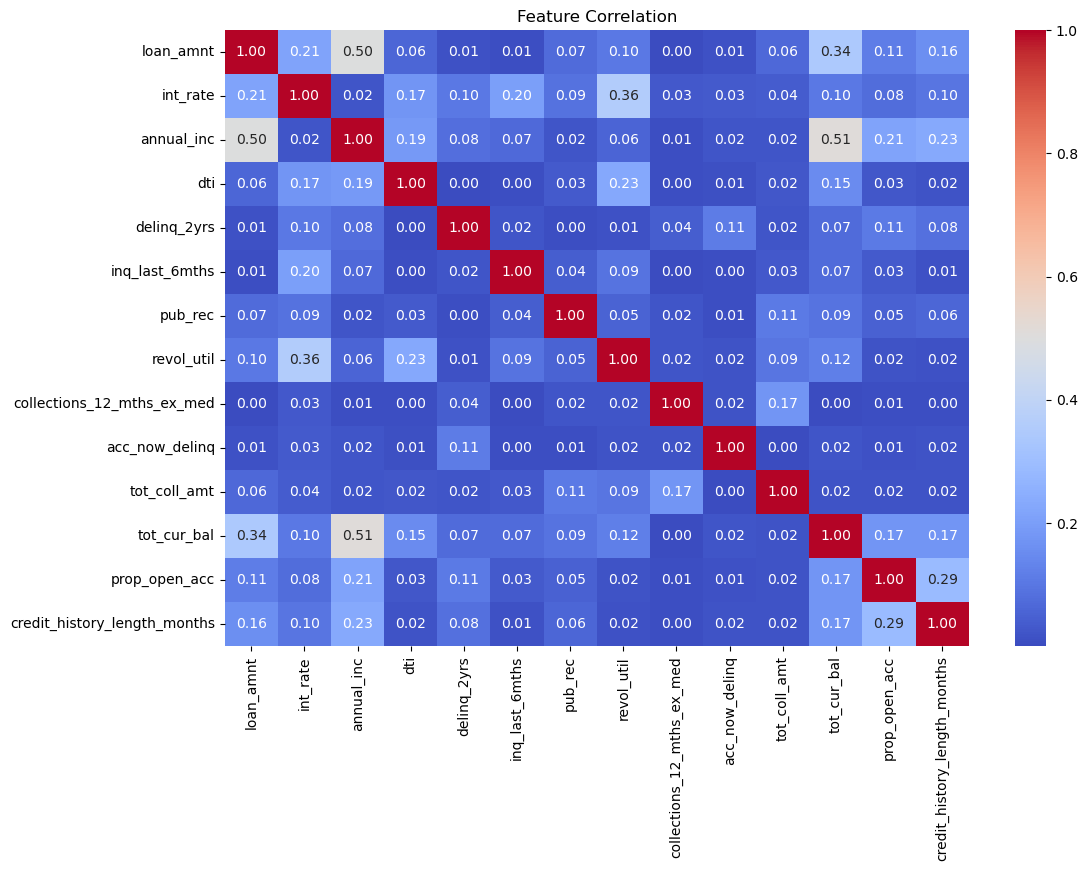

In [102]:
# Heatmap to check Multicollinearity
numeric_df = (df
              .drop(columns="loan_status")
              .select_dtypes(include=['number']))
corr_matrix = numeric_df.corr().abs()

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation')
plt.show()

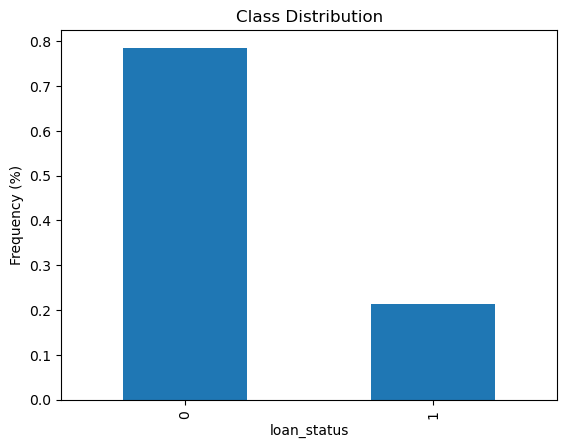

In [104]:
df["loan_status"].value_counts(normalize=True).plot(kind="bar")
plt.ylabel("Frequency (%)")
plt.title("Class Distribution")
plt.show()

From the bar chart we know that the class is Imbalanced. So we need to do OverSampler

## Split Data
In this step, we separate the dataset into the feature matrix (X) and the target vector (y), then split them into training, validation, and test sets.

In [108]:
# Create a feature matrix and target vector
target = "loan_status"
X = df.drop(columns=[target])
y = df[target]

In [110]:
# Split data to train data and test data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print(X.shape)
print(X_train.shape)

(237695, 21)
(190156, 21)


In [112]:
# Split train data to train data and validation data
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
print(X_train.shape)
print(X_val.shape)

(152124, 21)
(38032, 21)


## Baseline Model

In this step, we build a baseline dummy model to establish a minimum performance benchmark for our predictive model.

In [115]:
# Create a Baseline Model Accuracy
print("Baseline Model Accuracy: ",y_train.value_counts(normalize=True).round(2).max())

Baseline Model Accuracy:  0.79


We get this accuracy score from a model which only predicts the majority class, but since our data is imbalanced, we can't use accuracy score to determine whether our model is good or not. Therefore, we can use f1-score or ROC AUC instead of accuracy score that we show in the next cell.

In [118]:
# Split features to numeric and categorical features
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=np.number).columns.tolist()

In [120]:
# Create Pipeline for each features
numeric_pipeline = make_pipeline(
    SimpleImputer(strategy='median'), # Fill 'NaN' values with median
    StandardScaler() # Standardize Features
)

categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'), # Fill 'NaN' values with mode
    OneHotEncoder(handle_unknown='ignore') # Encode data
)

In [30]:
# Create a Logistic Regression model pipeline for baseline model
lr_model = make_pipeline(
    # Merge the both numeric and categorical pipelne using 'ColumnTransformer'
    ColumnTransformer(
        transformers=[("num",numeric_pipeline,numeric_features),("cat",categorical_pipeline,categorical_features)],
        remainder="passthrough"
    ),
    LogisticRegression(random_state=42,max_iter=1000)
)
lr_model.fit(X_train,y_train)
y_pred_base = lr_model.predict(X_val)
y_pred_base_proba=lr_model.predict_proba(X_val)[:,1]

# Use 'classification_report' to show f1 score
print("Classification Report (Validation Set):\n")
print(classification_report(y_val, y_pred_base))
print("-" * 30)

# Show ROC AUC score
base_roc_score = roc_auc_score(y_val, y_pred_base_proba).round(2)
print(f"ROC AUC Score (Validation Set): {base_roc_score}")
base_recall = recall_score(y_val,y_pred_base,pos_label=1).round(2)
print(f"Recall Score (class 1): {base_recall}")

Classification Report (Validation Set):

              precision    recall  f1-score   support

           0       0.80      0.98      0.88     29918
           1       0.56      0.09      0.15      8114

    accuracy                           0.79     38032
   macro avg       0.68      0.53      0.51     38032
weighted avg       0.75      0.79      0.72     38032

------------------------------
ROC AUC Score (Validation Set): 0.7
Recall Score (class 1): 0.09


## Model Building
At this step, several **machine learning model algorithms**, such as **Random Forest** and **XGBoost**, are constructed and subsequently assessed using **validation sets** to determine their performance score.

### Random Forest

In [33]:
# Create a pipeline for RandomForest Model
rf_pipeline = make_pipeline(
    # Merge the both pipeline using 'ColumnTransformer'
    ColumnTransformer(
        transformers= [("num",numeric_pipeline,numeric_features),("cat",categorical_pipeline,categorical_features)],
        remainder= "passthrough"
    ),
    # 'RandomOverSampler' for imbalance data
    RandomOverSampler(random_state=42),
    # The model
    RandomForestClassifier(random_state=42,n_jobs=-1)
)

In [34]:
# Do GridSearchCV for hyperparameter tuning
param_grid_rf = {
    'randomforestclassifier__n_estimators': [150, 160],
    'randomforestclassifier__max_depth': [10, 15],
    'randomforestclassifier__min_samples_leaf': [5],
    'randomforestclassifier__max_features': ['sqrt']
}

rf_model = GridSearchCV(
    estimator= rf_pipeline,
    param_grid= param_grid_rf,
    scoring= ["roc_auc","f1","recall"],
    refit= "f1",
    cv= 3,
    n_jobs= 1,
    verbose= 1
)
rf_model.fit(X_train,y_train)
print(rf_model.best_params_)
print(rf_model.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
{'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__n_estimators': 160}
0.44786134262854366


In [35]:
# Check random forest ROC AUC and recall score with validation sets
y_pred_rf = rf_model.predict(X_val)
y_pred_rf_proba = rf_model.predict_proba(X_val)[:,1]
print("Classification Report:\n")
print(classification_report(y_val,y_pred_rf))
print("-"*30)
rf_roc_score = roc_auc_score(y_val,y_pred_rf_proba).round(2)
print(f"Your RF Model ROC AUC SCORE: {rf_roc_score}")
print(f"Your Base Model(LR) ROC AUC SCORE: {base_roc_score}")
print(f"Your Model ROC AUC is {(rf_roc_score-base_roc_score)} than Baseline")
rf_recall = recall_score(y_val,y_pred_rf,pos_label=1).round(2)
print("-"*30)
print(f"Your RF Recall: {rf_recall}")
print(f"Your Base Recall: {base_recall}")
print(f"Your Model Recall is {(rf_recall-base_recall)} than Baseline")

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.70      0.77     29918
           1       0.35      0.60      0.44      8114

    accuracy                           0.67     38032
   macro avg       0.61      0.65      0.60     38032
weighted avg       0.75      0.67      0.70     38032

------------------------------
Your RF Model ROC AUC SCORE: 0.7
Your Base Model(LR) ROC AUC SCORE: 0.7
Your Model ROC AUC is 0.0 than Baseline
------------------------------
Your RF Recall: 0.6
Your Base Recall: 0.09
Your Model Recall is 0.51 than Baseline


### XGBoost

In [37]:
# Create a XGBoost pipeline
xgb_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[("num",numeric_pipeline,numeric_features),("cat",categorical_pipeline,categorical_features)],
        remainder="passthrough"
    ),
    RandomOverSampler(random_state=42),
    XGBClassifier(random_state=42,eval_metric="logloss",use_label_encoder=False)
)

In [38]:
# Create XGBoost model
param_grid_xgb = {
    # Sedikit menurunkan bobot untuk mengurangi recall & mendorong precision
    "xgbclassifier__scale_pos_weight": [2.5],
    "xgbclassifier__n_estimators": [200, 300],
    "xgbclassifier__learning_rate": [0.05, 0.1],
    "xgbclassifier__max_depth": [4, 5],
    "xgbclassifier__gamma": [0.5],
    "xgbclassifier__reg_lambda": [3],   
    "xgbclassifier__subsample": [0.8],
    "xgbclassifier__colsample_bytree": [0.8]
}

# use 'GridSearchCV' for hyperparameter tuning
xgb_model = GridSearchCV(
    estimator= xgb_pipeline,
    param_grid= param_grid_xgb,
    scoring= ["recall","roc_auc","f1"],
    refit="f1",
    cv= 5,
    n_jobs= 1,
    verbose= 1
)

# XGBoost model train
xgb_model.fit(X_train,y_train)

print("Best XGBoost params:", xgb_model.best_params_)
print("Best XGBoost score:", xgb_model.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


D:\anacon\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:05] WARNING: D:\bld\xgboost-split_1737531311373\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
D:\anacon\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:07] WARNING: D:\bld\xgboost-split_1737531311373\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
D:\anacon\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:09] WARNING: D:\bld\xgboost-split_1737531311373\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
D:\anacon\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:12] WARNING: D:\bld\xgboost-split_1737531311373\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
D:\anacon\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:14] WARNING: D:

Best XGBoost params: {'xgbclassifier__colsample_bytree': 0.8, 'xgbclassifier__gamma': 0.5, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 300, 'xgbclassifier__reg_lambda': 3, 'xgbclassifier__scale_pos_weight': 2.5, 'xgbclassifier__subsample': 0.8}
Best XGBoost score: 0.4074651630746934


In [39]:
# Check XGBoost ROC AUC and recall score with validation sets
y_pred_xgb = xgb_model.predict(X_val)
y_pred_xgb_proba = xgb_model.predict_proba(X_val)[:,1]
print("Classification Report:\n")
print(classification_report(y_val,y_pred_xgb))
print("-"*30)
xgb_roc_score = roc_auc_score(y_val,y_pred_xgb_proba).round(2)
print(f"Your XGB Model ROC AUC SCORE: {xgb_roc_score}")
print(f"Your Base Model(LR) ROC AUC SCORE: {base_roc_score}")
print(f"Your Model ROC AUC is {(xgb_roc_score-base_roc_score)} than Baseline")
xgb_recall = recall_score(y_val,y_pred_xgb,pos_label=1).round(2)
print("-"*30)
print(f"Your XGB Recall: {xgb_recall}")
print(f"Your Base Recall: {base_recall}")
print(f"Your Model Recall is {(xgb_recall-base_recall)} than Baseline")

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.29      0.45     29918
           1       0.26      0.90      0.40      8114

    accuracy                           0.42     38032
   macro avg       0.59      0.60      0.42     38032
weighted avg       0.78      0.42      0.44     38032

------------------------------
Your XGB Model ROC AUC SCORE: 0.7
Your Base Model(LR) ROC AUC SCORE: 0.7
Your Model ROC AUC is 0.0 than Baseline
------------------------------
Your XGB Recall: 0.9
Your Base Recall: 0.09
Your Model Recall is 0.81 than Baseline


### Save Model

In [41]:
# Save the Random Forest Model as "random_forest_model.pkl" using pickle
with open("random_forest_model.pkl","wb") as f:
    pickle.dump(rf_model.best_estimator_,f)

with open("xgb_model.pkl","wb") as f:
    pickle.dump(xgb_model.best_estimator_,f)
    
print("The Model has been successfully saved")

The Model has been successfully saved


## Model Evaluation
At this step, the model will be evaluated using the test set to definitively ascertain its capability to perform effectively and generalize well when exposed to new, previously unseen data.

In [136]:
# Load both random forest and stack model
with open("random_forest_model.pkl","rb") as f:
    loaded_rf_model = pickle.load(f)
with open("xgb_model.pkl","rb") as f:
    loaded_xgb_model = pickle.load(f)

print("All models have been successfully loaded")

All models have been successfully loaded


In [44]:
loaded_models = {"Random Forest":loaded_rf_model,"XGBoost":loaded_xgb_model}
for model in loaded_models:
    y_pred_test = loaded_models[model].predict(X_test)
    y_pred_test_proba = loaded_models[model].predict_proba(X_test)[:,1]
    test_roc_score = roc_auc_score(y_test,y_pred_test_proba).round(2)
    test_recall = recall_score(y_test,y_pred_test,pos_label=1).round(2)
    print(model)
    print("-"*30)
    print(f"{model} ROC AUC score: {test_roc_score:.2f}")
    print(f"{model} Recall Score: {test_recall:.2f}\n")

Random Forest
------------------------------
Random Forest ROC AUC score: 0.71
Random Forest Recall Score: 0.61

XGBoost
------------------------------
XGBoost ROC AUC score: 0.71
XGBoost Recall Score: 0.91



Based on the model evaluation results from the test set, we can conclude that the XGBoost model demonstrates superior performance compared to the Random Forest model. While both models have same ROC AUC scores at 0.71, the significant advantage of XGBoost is evident in its Recall Score of 0.91, far surpassing the 0.61 achieved by Random Forest. This indicates a much stronger capability of the XGBoost model to correctly identify true positive cases. **Therefore, due to its superior performance, we will utilize the XGBoost model for the prediction function moving forward**.

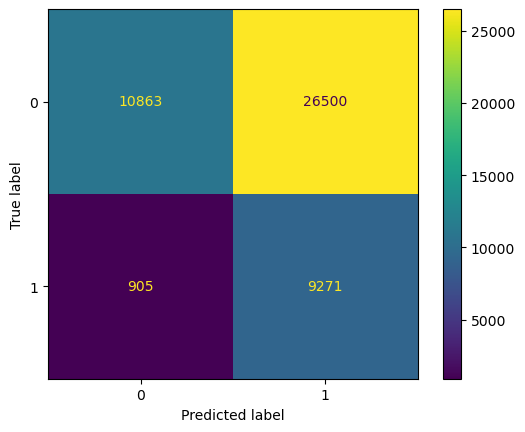

In [92]:
# Create Confusion Matrix
cm = confusion_matrix(y_test,y_pred_test)
cmdisp = ConfusionMatrixDisplay(confusion_matrix= cm)

# Create Confusion Matrix Display
cmdisp.plot()

## Communicate Results
This step involves communicating the findings, specifically presenting the **feature importance graph** which highlights the most critical features for the model, along with the **predict function** that returns a percentage representing a customer's likelihood of experiencing **credit risk**.

### Feature Importances

In [140]:
# Create 'permutation_importance'
feat_imp = permutation_importance(
    estimator= loaded_xgb_model,
    X= X_test,
    y= y_test,
    n_repeats= 10,
    random_state= 42,
    n_jobs=-1,
    scoring="f1"
)

In [141]:
# Create feature importance dataframe
feat_names = X_test.columns
feat_imp_df = pd.DataFrame({"feature":feat_names,"importance_mean":feat_imp.importances_mean})

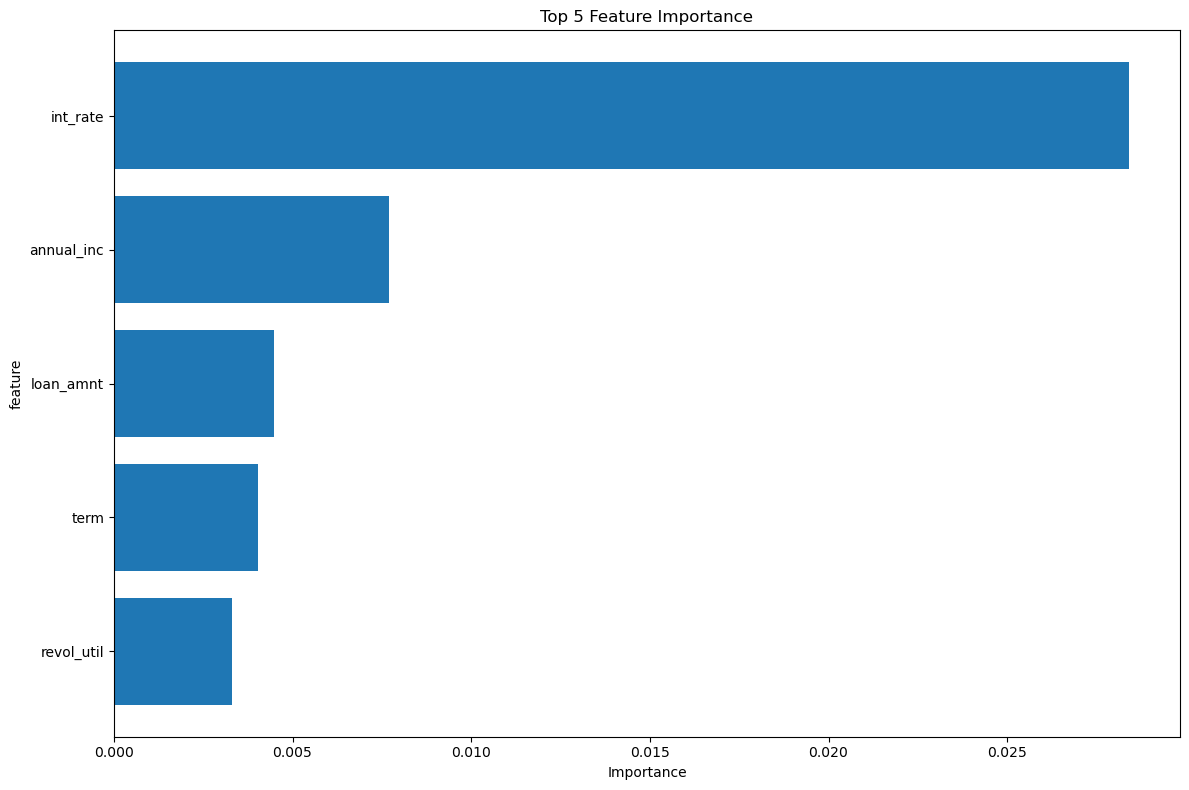

In [142]:
# Create a visualization using horizontal bar chart
feat_imp_df = feat_imp_df.sort_values("importance_mean",key=abs,ascending=True).tail(5)

plt.figure(figsize=(12,8))
plt.barh(feat_imp_df["feature"],feat_imp_df["importance_mean"])
plt.xlabel("Importance")
plt.ylabel("feature")
plt.title("Top 5 Feature Importance")
plt.tight_layout()
plt.show()

Based on the Top 5 Feature Importance horizontal bar chart 👆, the int_rate (interest rate) is overwhelmingly the most influential feature, indicating that your model's predictions are highly dependent on this single variable. The annual_inc (annual income) serves as a significant secondary predictor, although its importance is substantially lower than that of the interest rate. The remaining features—loan_amnt (loan amount), term (loan term), and revol_util (revolving credit utilization)—demonstrate a comparatively minor impact on the model's performance. This hierarchy suggests the model has effectively learned that financial risk (reflected in int_rate) and a borrower's repayment capacity (indicated by annual_inc) are the most critical factors for its predictions, which is characteristic of a financial or credit assessment model.

### Prediction

In [88]:
# Create a 'predict_risk' function
def predict_risk(data):
    """
    Predict credit risk from new data and return the probability series.

    Args:
        data (pd.Dataframe): Data containing customer data.

    Returns:
        pd.Series: The series contains the risk probabilities for each customer.
    """
    # Load the model
    with open("xgb_model.pkl","rb") as f:
        model = pickle.load(f)
        
    # Get probability
    probabilities = model.predict_proba(data)[:,1]
    risk_proba = [f"{(proba*100):.2f}%" for proba in probabilities]

    return pd.Series(risk_proba).rename("credit_risk_proba")

In [90]:
sample_data = X_test[:5]
predict_risk(sample_data)

0    57.52%
1    74.78%
2    91.94%
3    38.50%
4    65.70%
Name: credit_risk_proba, dtype: object

The value returned by the **predict\_risk function** is a Series containing the percentage of **credit risk** for each customer; this function utilizes a **confidence interval** approach rather than making a definitive judgment.